# Analysis

In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [168]:
sns.set(rc={'figure.figsize':(10,7)})
plt.style.use('seaborn-whitegrid')

In [165]:
year = '17'

## Data preparation

In [166]:
f = uproot.pandas.iterate("../outputs/"+year+"/trees/*.root", "t", reportpath = True,
                          branches=['beam_energy', 'mass', 'trigger', 'procedure'])

In [167]:
dataRAW = pd.concat([j.assign(name=float(re.findall(r"\d+\.\d+", path)[0])) for path,j in f])

In [169]:
dataRAW.sort_values(by='name', ascending=True, inplace=True);

Количество уникальных `name` в `data` должно совпадать с количеством точек в сезоне
* 17 год: 34 точки
* 19 год: 44 точки
* моделирование: 38 точек

In [170]:
print("Checking:", len(dataRAW.name.unique()), 'different names in', year, 'season')

Checking: 34 different names in 17 season


Проверка типов полей датафрейма

In [171]:
dataRAW.dtypes

beam_energy    float64
mass           float64
trigger          int32
procedure        int32
name           float64
dtype: object

Проверка данных

In [172]:
dataRAW.describe()

,beam_energy,mass,trigger,procedure,name
count,3208.000000,3208.000000,3208.000000,3208.000000,3208.000000
mean,826.169480,302.772685,1.489713,1.939526,826.382793
std,116.942585,243.067960,0.766394,0.645018,116.982732
min,641.018494,-1.000000,-1.000000,1.000000,641.000000
25%,724.939209,3.116568,1.000000,2.000000,725.000000
50%,839.471375,490.159897,2.000000,2.000000,840.000000
75%,938.176819,501.111031,2.000000,2.000000,938.300000
max,1003.312012,577.590027,2.000000,3.000000,1003.500000


Проверить триггер

In [173]:
bad_trig = dataRAW.query('trigger<0')
print('Energy points with bad trigger:\n', bad_trig.name.value_counts())

Energy points with bad trigger:
 939.6    1
Name: name, dtype: int64


Проверить энергии

In [174]:
bad_en = dataRAW.query('beam_energy<0')
print('Bad energy records:', bad_en.name.shape[0])

Bad energy records: 0


Удалить события с плохим триггером и энергиями (не в моделировании)

In [175]:
data = dataRAW if 'model' in year else dataRAW.query('trigger>-1&beam_energy>0')

Оставить только массы внутри окна (450,550) и без процедуры kinfit

In [176]:
data = data.query('mass>450&mass<550&procedure!=1')

In [177]:
print(data.shape[0], 'records left')

1776 records left


Удалить ненужные столбцы

In [178]:
data.drop('procedure', axis=1, inplace=True)

In [179]:
data.head()

,beam_energy,mass,trigger,name
333,641.018494,501.645905,2,641.0
363,641.018494,498.146912,2,641.0
362,641.018494,497.903320,2,641.0
361,641.018494,494.001068,2,641.0
360,641.018494,509.590729,0,641.0


Добавить светимости

In [180]:
lum = pd.read_csv(f'../inputs/{year}/lum.dat')
lum.rename({'label': 'name'}, axis=1, inplace=True)
if 'err' in lum.columns:
    lum.drop(['err'], axis=1, inplace=True) #ошибка светимостей уходит в систематику
    
lum = lum.sort_values(by='name')

In [181]:
lum.tail()

,name,lum
29,960.0,1350.78
30,971.0,1775.70
31,981.0,1322.97
32,990.0,1246.80
33,1003.5,3788.26


Проверить данные (хорошо, если числа совпадают)

Если не совпадают, то проверить светимости на дубликаты

In [182]:
print('Records in  lum:', lum.shape[0])
print('Records in data:', data.name.unique().shape[0])

Records in  lum: 34
Records in data: 34


Объединить данные и светимость

In [183]:
data_prep = lum.merge(data, on='name')

In [184]:
def check_foo(data1, data2):
    if(data1.shape[0] == data2.shape[0]):
        print("Good.", data1.shape[0], 'rows' )
    else:
        print("WARNING. frames haven't equal shape |", data1.shape[0], 'vs', data2.shape[0], 'records')
    return

In [185]:
check_foo(data_prep, data)

Good. 1776 rows


Смотрим, в каких именно точках не совпадают `data` и `lum`

In [186]:
set1 = set(data.name.unique())
set2 = set(lum.name.unique())

(set1|set2).difference(set1&set2)

set()

### Pictures

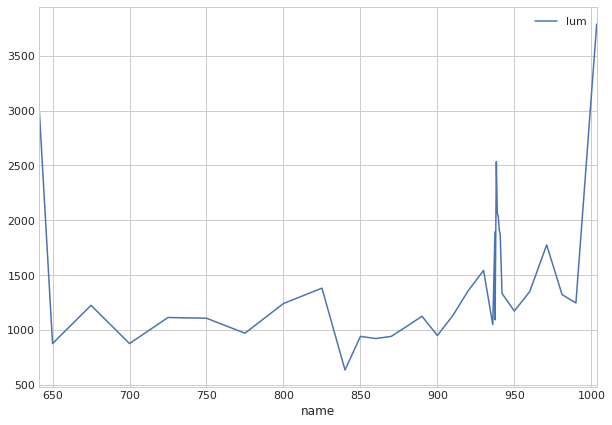

In [187]:
lum.plot(x='name', y='lum')

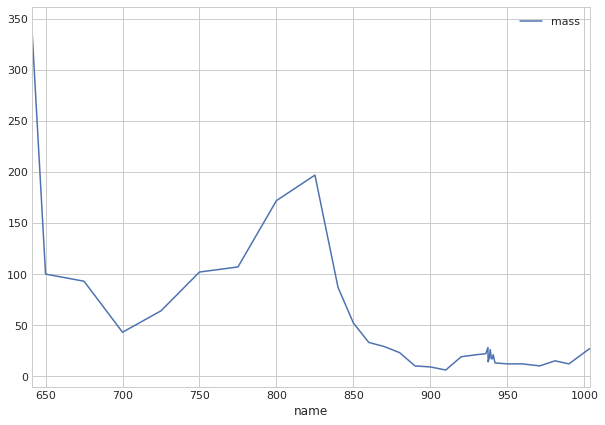

In [188]:
data_prep.groupby('name').agg({'mass':np.size}).plot()

In [189]:
data_prep.groupby('name').agg({'mass':np.size})

,mass
name,
641.0,345.0
650.0,100.0
675.0,93.0
700.0,43.0
725.0,64.0
750.0,102.0
775.0,107.0
800.0,172.0
825.0,197.0


Слияние точек

In [190]:
cnct = []
if year=='11':
    cnct = [([875., 887.5], 880), ([900., 912.5, 925.], 910), ([935., 945., 950., 962.5, 975., 987.5, 1000.], 950)] #11year
if year=='12':
    cnct = [([900., 920., 936., 950., 960., 970., 980., 990], 960)] #12 year
if year=='17':
    cnct = [([880., 890., 900., 910.], 900), ([920., 930., 936., 937.5], 935), 
            ([942., 950., 960., 971.], 960), ([981., 990, 1003.5],990)] #17 year
if year=='19':
    cnct = [([862.5, 875.0, 887.5, 900.0, 912.5, 925], 875),([936, 945.0, 950.0, 951.1, 955.0, 962.5], 955),
            ([975., 978.0, 987.5], 980)] #19year

In [191]:
for c in cnct:
    data_prep.name.replace(c[0], c[1], inplace=True)

OK, points have been merged

In [192]:
data_prep.tail()

,name,lum,beam_energy,mass,trigger
1771,990.0,3788.26,1003.312012,532.163147,2
1772,990.0,3788.26,1003.312012,504.815674,2
1773,990.0,3788.26,1003.312012,526.116394,2
1774,990.0,3788.26,1003.312012,541.355103,2
1775,990.0,3788.26,1003.312012,525.965332,2


In [193]:
check_foo(data_prep, data)

Good. 1776 rows


### Пересчитать светимости в слитых точках

In [194]:
data_prep['lume'] = data_prep.beam_energy*data_prep.lum

Проверить правильность слияния

In [195]:
#число в поле lum с количеством элементов в списке для слияния
data_prep[['lum', 'name']].\
drop_duplicates(subset=['name','lum']).groupby('name').agg({'lum':np.size}).query('lum!=1')

,lum
name,
900.0,4.0
935.0,4.0
960.0,4.0
990.0,3.0


In [196]:
new_lum = data_prep[['beam_energy', 'lum', 'lume', 'name']].drop_duplicates(subset=['lum','name']).\
groupby('name').agg({'lume':[np.sum], 'lum':[np.sum], 'beam_energy':[np.min, np.max]})

In [197]:
new_lum.shape

(23, 4)

In [198]:
new_lum['Emean'] = np.round( new_lum[('lume','sum')]/new_lum[('lum','sum')], 2)

In [199]:
new_lum.columns = ['lume', 'lum', 'dEmin', 'dEmax', 'Emean']
new_lum.drop('lume', axis=1, inplace=True)
new_lum['dEmax'] = np.abs( np.round( new_lum.dEmax-new_lum.Emean, 2) )
new_lum['dEmin'] = np.abs( np.round( new_lum.Emean - new_lum.dEmin, 2) )

In [200]:
#data.loc[641.].beam_energy.std()

In [201]:
new_lum.query('dEmin>0')

,lum,dEmin,dEmax,Emean
name,,,,
900.0,4238.757,17.01,15.74,893.98
935.0,5042.760,10.17,6.99,930.13
960.0,5632.170,15.52,13.84,957.40
990.0,6358.030,14.54,6.81,996.50


I have got new luminosity table.

Now I should join it to existing table

In [202]:
data_prep.drop(['lume', 'lum', 'beam_energy'], axis=1, inplace=True)

In [203]:
final_data = data_prep.join(new_lum, how='inner', on='name')

In [204]:
check_foo(final_data, data_prep)

Good. 1776 rows


That is good. Now I should do the analysis

In [205]:
final_data.tail()

,name,mass,trigger,lum,dEmin,dEmax,Emean
1771,990.0,532.163147,2,6358.03,14.54,6.81,996.5
1772,990.0,504.815674,2,6358.03,14.54,6.81,996.5
1773,990.0,526.116394,2,6358.03,14.54,6.81,996.5
1774,990.0,541.355103,2,6358.03,14.54,6.81,996.5
1775,990.0,525.965332,2,6358.03,14.54,6.81,996.5


----------------
## Fit

In [206]:
data2 = final_data.groupby('name')

In [207]:
dic = {}
for i in data2.groups:
    print(i)
    dic[i] = np.array( data2.get_group(i)['mass'] )

641.0
650.0
675.0
700.0
725.0
750.0
775.0
800.0
825.0
840.0
850.0
860.0
870.0
900.0
935.0
937.4
938.3
938.9
939.6
940.2
940.8
960.0
990.0


In [208]:
import iminuit
import probfit as pf

In [209]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(16,9)})

In [210]:
mass_bound = (450, 550)

In [229]:
#2 гаусса
def constant(x):
    return 1
def two_gauss(x, mu, sigma1, sigma2, frac):
    return frac*pf.gaussian(x, mu, sigma1) + (1-frac)*pf.gaussian(x, mu, sigma2)

norm_sig = pf.rename( pf.Normalized( two_gauss, mass_bound ), ['x', 'M', '$\sigma1$', '$\sigma2$', 'f'] )
norm_bkg = pf.Normalized( constant, mass_bound )

ext_sig = pf.Extended(norm_sig, extname='$N_{sig}$')
ext_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

pdf = pf.AddPdf(ext_sig, ext_bkg)

sigma1Lim = (5.77, 0)
sigma2Lim = (13.43, 0)

limits = {
    "limit_M": [497.6-5, 497.6+5],
    "limit_$\sigma1$": [sigma1Lim[0] - sigma1Lim[1], sigma1Lim[0] + sigma1Lim[1]],
    "limit_$\sigma2$": [sigma2Lim[0] - sigma2Lim[1], sigma2Lim[0] + sigma2Lim[1]],
    "limit_$N_{sig}$": [0, 10000],
    "limit_$N_{bkg}$": [0, 1000],
    "limit_f": [0, 1]
}
errors = {
    "error_M": 1,
    "error_$\sigma1$": 0.,
    "error_$\sigma2$": 0.,
    "error_$N_{sig}$": 0.3,
    "error_$N_{bkg}$": 0.1,
    "error_f": 0.05
}

# norm_sig1 = pf.Normalized( pf.rename(pf.gaussian, ['x', 'm', '$\sigma1$']), mass_bound)
# norm_sig2 = pf.Normalized( pf.rename(pf.gaussian, ['x', 'm', '$\sigma2$']), mass_bound)
# norm_bkg = pf.Extended(norm_bkg, extname='$N_{bkg}$')

# gauss1 = pf.Extended(norm_sig1, extname='$N_{sig1}$')
# gauss2 = pf.Extended(norm_sig2, extname='$N_{sig2}$')

# pdf = pf.AddPdf(gauss1, gauss2, norm_bkg)
pf.describe(pdf)

# limits = {"limit_m": [497.6, 497.6], "limit_$\sigma1$": [4.26, 4.26], "limit_$\sigma2$": [11.16, 11.16],  
#           "limit_$N_{sig1}$": [0, 10000], "limit_$N_{sig2}$": [0, 10000], "limit_$N_{bkg}$": [0, 1000]}
# errors = {"error_m": 1, "error_$\sigma1$": 0., "error_$\sigma2$": 0. , 
#           "error_$N_{sig1}$": 0.3, "error_$N_{sig2}$": 0.3, "error_$N_{bkg}$":0}

['x', 'M', '$\\sigma1$', '$\\sigma2$', 'f', '$N_{sig}$', '$N_{bkg}$']

In [227]:
def fitter(dic, nbins, energy, binnedLik=False, simple_plot=True):
    
    likelihood = pf.UnbinnedLH(pdf, dic, extended=True, extended_bound=mass_bound) if not(binnedLik) else \
    pf.BinnedLH(pdf, dic, int(nbins*(mass_bound[1]-mass_bound[0])/100.), bound=mass_bound, extended=True)
    
    initial_par_values = {"M": 497.6, "$\sigma1$": 4.26, "$N_{sig}$": np.size(dic)/2.,
                          "$\sigma2$": 11.16, "f": 0.5, "$N_{bkg}$": 1}
    mt = iminuit.Minuit(likelihood, **initial_par_values, **errors, **limits, pedantic=False)
    mt.migrad();
        
    if simple_plot:
        likelihood.draw(minuit=mt) if binnedLik else likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)
    else:
        fig = plt.figure(figsize=(16, 10), dpi= 80)
        grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

        # Define the axes
        ax_main = fig.add_subplot(grid[:-1, :])

        if binnedLik:
            likelihood.draw(minuit=mt)
        else:
            likelihood.draw(minuit=mt, bins=nbins, bound=mass_bound)

        plt.tick_params(labelsize=20);
        plt.xlabel('invariant mass, MeV', fontsize=20)
        plt.ylabel('number of events', fontsize=20)

        # this is an inset axes over the main axes
        ax_bottom = fig.add_subplot(grid[-1, :], xticklabels=[])
        likelihood.draw_residual(minuit=mt) if binnedLik else \
        likelihood.draw_residual(minuit=mt, bins=nbins, bound=mass_bound)
    
        plt.savefig(f'../outputs/{year}/figures/fit_e{energy}.png')
    return mt, likelihood

In [213]:
itr = iter(dic)

In [214]:
fit_frame = pd.DataFrame(columns=[ 'M', 'S1', 'S2', 'f', 'N', 'C', 
                                  'Merr', 'S1err', 'S2err', 'ferr', 'Nerr', 'Cerr'])

In [285]:
i = next(itr)
print('Label:', i)

StopIteration: 

Migrad quality: True
Real: 54 Found: 53.998788197495145


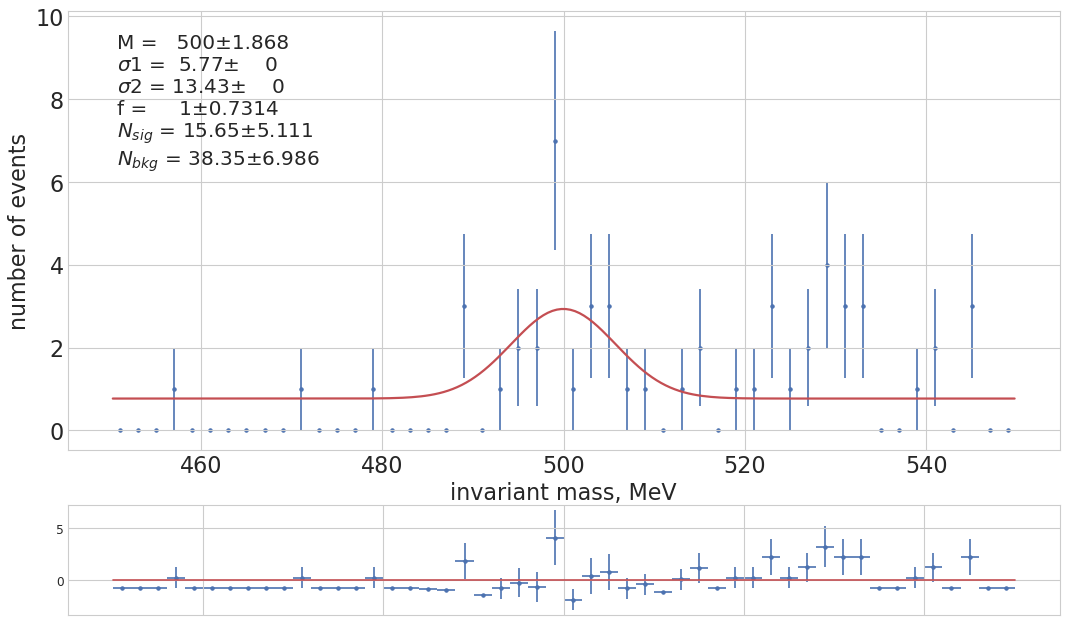

In [282]:
#mass_bound = (450, 550)
number = 10
dicx = dic[i]#final_data.query('name>@emin_an[@number]&name<=@emax_an[@number]').mass.values#dic[i]#
mt, lik = fitter(dicx, 50, i, False, False)
fit_frame.loc[i] = mt.values.values() + mt.errors.values()
print("Migrad quality:", mt.migrad_ok())
print( 'Real:', np.size(dicx), 'Found:', mt.values['$N_{sig}$'] + mt.values['$N_{bkg}$'] )

In [283]:
fit_frame

,M,S1,S2,f,N,C,Merr,S1err,S2err,ferr,Nerr,Cerr
641.0,497.724867,5.77,13.43,0.726996,329.451943,15.527003,0.415860,0.0,0.0,0.061344,19.498623,8.139456
650.0,499.010999,5.77,13.43,0.716097,99.984513,0.000090,0.745832,0.0,0.0,0.090737,9.998704,2.260909
675.0,496.213303,5.77,13.43,0.740446,85.585588,7.417727,0.828138,0.0,0.0,0.129110,10.044258,4.764455
700.0,495.403327,5.77,13.43,0.503174,39.539176,3.518691,1.543097,0.0,0.0,0.222449,6.909789,3.417241
725.0,499.840125,5.77,13.43,0.640382,62.339447,1.651929,1.089763,0.0,0.0,0.159540,8.291776,2.841736
750.0,499.971575,5.77,13.43,0.518061,97.122267,4.877391,0.940881,0.0,0.0,0.126171,10.480643,4.193113
775.0,498.717663,5.77,13.43,0.443086,106.979811,0.000009,0.924720,0.0,0.0,0.107127,10.342441,1.820668
800.0,499.510848,5.77,13.43,0.480728,165.801698,6.258122,0.738614,0.0,0.0,0.090489,13.338868,4.280732
825.0,498.838078,5.77,13.43,0.490255,191.622425,5.453499,0.685354,0.0,0.0,0.084074,14.294359,4.256498
840.0,498.499658,5.77,13.43,0.528056,80.976600,6.103385,1.053859,0.0,0.0,0.142646,9.614629,4.186032


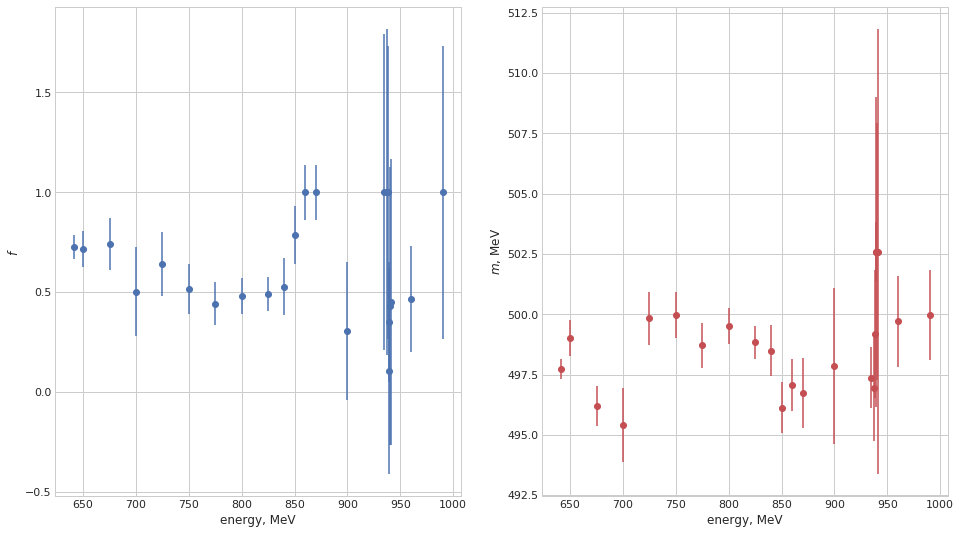

In [284]:
plt.subplot(1, 2, 1)
plt.errorbar(x=fit_frame.index, y=fit_frame.f, yerr=fit_frame.ferr, fmt='o')
plt.xlabel('energy, MeV');
plt.ylabel('$f$');
plt.subplot(1, 2, 2)
plt.errorbar(x=fit_frame.index, y=fit_frame.M, yerr=fit_frame.Merr, fmt='or')
plt.xlabel('energy, MeV');
plt.ylabel('$m$, MeV');

### Some notes:
none

## Анализ $\sigma$

### 19 год

В точках 550 и 550.1 принципиально различается ширина ( 4.8 vs 6.12 )

В 19 году взял группами точки по энергии и посмотрел их $\sigma$, видно, что ширина растёт вместе с энергией

<ErrorbarContainer object of 3 artists>

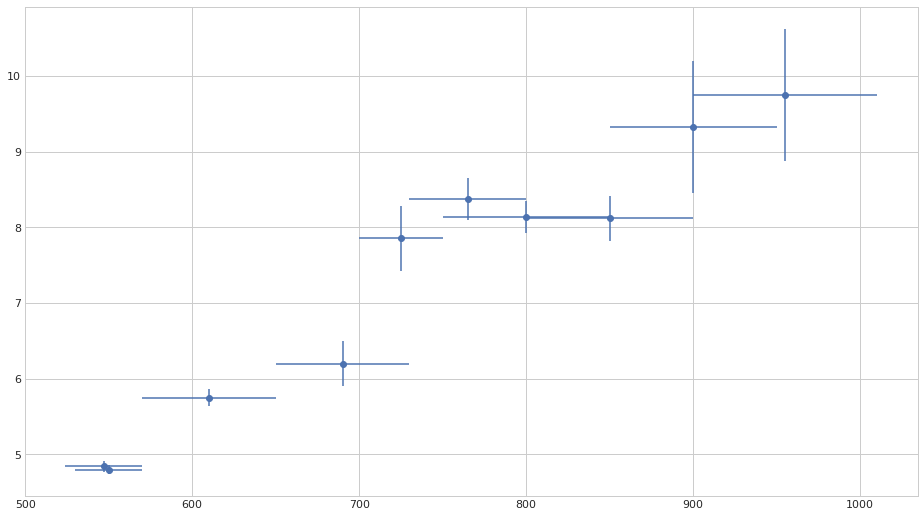

In [222]:
emin_an  = [524, 570, 650, 730, 800, 900, 850, 750, 700, 530]
emax_an  = [570, 650, 730, 800, 900, 1010, 950, 850, 750, 570]
sigma_an = [4.84, 5.75, 6.2, 8.38, 8.12, 9.75, 9.33, 8.14, 7.86, 4.8]
dsigma_an = [0.069, 0.11, 0.3, 0.28, 0.3, 0.87, 0.87, 0.21, 0.43, 0.06]
df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma':sigma_an, 'ds': dsigma_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
plt.errorbar(data=df_sigma_an, x='emean', y='sigma', xerr='deup', yerr='ds', fmt='o')

Возникает гипотеза (ещё и с учётом того факта, что на большой статистике данные описываются не идеально) добавить ещё один гаусс. Посмотрим, что из этого выйдет.

Повторю распределение сигм по аналогии с картинкой выше

<ErrorbarContainer object of 3 artists>

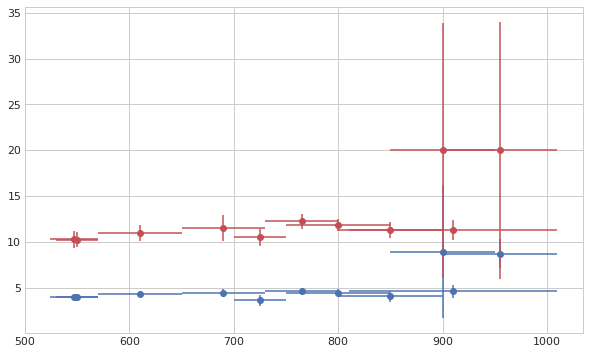

In [552]:
plt.rcParams.update({'font.size': 18, 'figure.figsize':(10,6)})
emin_an  = [524, 570, 650, 730, 800, 900, 850, 750, 700, 530, 810]
emax_an  = [570, 650, 730, 800, 900, 1010, 950, 850, 750, 570, 1010]
sigma1_an = [4.02, 4.31, 4.44, 4.66, 4.08, 8.724847949065675, 8.952093654550044, 4.509152675111134, 3.6841658856535178, 4.01709961911671, 4.628942053127934]
dsigma1_an = [0.13, 0.18, 0.44, 0.39, 0.55, 1.590062670581002, 7.270944904440277, 0.3453623743108212, 0.6048651400716212, 0.1190920659859942, 0.7016815273028718]
sigma2_an = [10.3, 10.98, 11.55, 12.25, 11.34, 19.995900427431625, 19.999882612152, 11.866375420268561, 10.53279261428423, 10.283255759137344, 11.339313291171166]
dsigma2_an = [0.9, 0.85, 1.42, 0.81, 0.89, 13.996992016425061, 13.933962567163773, 0.6617076556061905, 0.9474962757272731, 0.8289418695468278, 1.1023824322696134]
frac12_an = [3.92, 2.31, 1.76, 0.88, 0.64, 2.728843351319719, 6.911293728105318, 0.8379169741736125, 0.7006647553677061, 3.9196405944377877, 0.62839843050261]
df_sigma_an = pd.DataFrame({'emin':emin_an, 'emax':emax_an, 'sigma1':sigma1_an, 'ds1': dsigma1_an, 
                            'sigma2':sigma2_an, 'ds2': dsigma2_an, 'frac': frac12_an})
df_sigma_an['emean'] = (df_sigma_an.emin + df_sigma_an.emax)/2.
df_sigma_an['deup'] = df_sigma_an.emean - df_sigma_an.emin
plt.errorbar(data=df_sigma_an, x='emean', y='sigma1', xerr='deup', yerr='ds1', fmt='ob')
plt.errorbar(data=df_sigma_an, x='emean', y='sigma2', xerr='deup', yerr='ds2', fmt='or')

Видно, что каждая из сигм практически не сдвигается. Но видно, что на малом объёме данных ширины начинают расплываться (заметно при высоких энергиях)

Зафиксирую ширины на средних без учёта выпавших точек

In [238]:
print('Sigma1:', df_sigma_an.drop([5,6]).sigma1.mean() )
print('Sigma2:', df_sigma_an.drop([5,6]).sigma2.mean() )

Sigma1: 4.261040025889923
Sigma2: 11.160193009429035


Тогда проверяю предположение, что $\sigma$ в случае одного гаусса меняется из-за того, что меняется доля событий под узким и широким гауссами меняется с энергией

<ErrorbarContainer object of 3 artists>

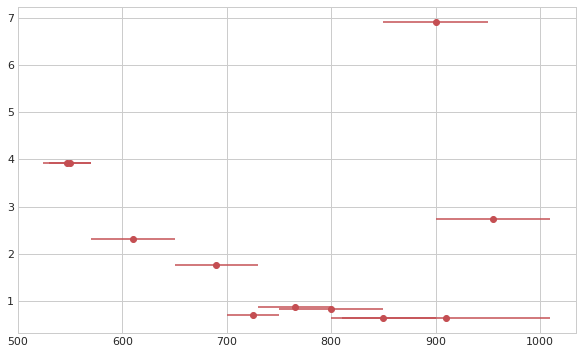

In [314]:
plt.errorbar(data=df_sigma_an, x='emean', y='frac', xerr='deup', fmt='or')

Теперь 2 гаусса для моделирования (`model_new`)

<ErrorbarContainer object of 3 artists>

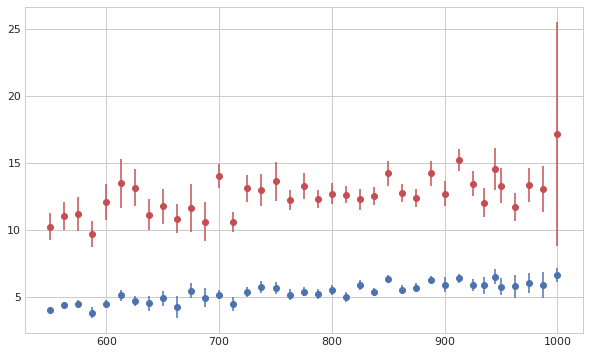

In [553]:
en_an = [ 550. ,  562.5,  575. ,  587.5,  600. ,  612.5,  625. ,  637.5,
        650. ,  662.5,  675. ,  687.5,  700. ,  712.5,  725. ,  737.5,
        750. ,  762.5,  775. ,  787.5,  800. ,  812.5,  825. ,  837.5,
        850. ,  862.5,  875. ,  887.5,  900. ,  912.5,  925. ,  935. ,
        945. ,  950. ,  962.5,  975. ,  987.5, 1000. ]
s1_an = [4.00928888, 4.33747255, 4.43559649, 3.803059  , 4.423181  ,
       5.1014904 , 4.66565474, 4.5045961 , 4.87810257, 4.1960529 ,
       5.43876272, 4.91843674, 5.14132747, 4.45975828, 5.31429813,
       5.69505078, 5.60314509, 5.14196975, 5.3540354 , 5.16952826,
       5.50877517, 4.94773543, 5.86872395, 5.33462472, 6.33305366,
       5.50748813, 5.64094449, 6.22043922, 5.8916277 , 6.35738374,
       5.86313576, 5.82890009, 6.48632741, 5.73844622, 5.75707775,
       6.0104084 , 5.87187928, 6.64138695]
s2_an = [10.24281036, 11.05319352, 11.18820377,  9.68060542, 12.08471558,
       13.48858781, 13.14961493, 11.13335416, 11.74951692, 10.83995468,
       11.62019776, 10.61195066, 13.99189698, 10.58376123, 13.09259816,
       12.95582443, 13.64101323, 12.22498239, 13.24488383, 12.3034521 ,
       12.69676957, 12.62291336, 12.27461984, 12.50987221, 14.22699406,
       12.77836884, 12.39655738, 14.23327043, 12.70892288, 15.21270754,
       13.44290652, 12.03170836, 14.54893378, 13.31082015, 11.72120822,
       13.3503376 , 13.0830581 , 17.15999921]
s1err_an = [0.24420247, 0.23628817, 0.2793554 , 0.43500637, 0.30562574,
       0.41426316, 0.36829545, 0.57240212, 0.55104936, 0.83858414,
       0.54760894, 0.72628265, 0.32523255, 0.51859386, 0.3644784 ,
       0.43592776, 0.44839775, 0.42269701, 0.32609865, 0.3645667 ,
       0.37670574, 0.36108701, 0.38803313, 0.29671017, 0.31075945,
       0.34238496, 0.33784375, 0.2866558 , 0.54865994, 0.35272085,
       0.43615359, 0.64643721, 0.55803832, 0.61537946, 0.86046785,
       0.71916831, 0.972075  , 0.51998215]
s2err_an = [1.02206463, 1.06032287, 1.28551181, 1.00666387, 1.33649728,
       1.83713476, 1.38658335, 1.13404142, 1.28373445, 1.08777375,
       1.78985585, 1.48944632, 0.89674085, 0.7724873 , 1.03681978,
       1.19733482, 1.46254629, 0.7502984 , 0.97471297, 0.6738531 ,
       0.78451445, 0.65602477, 0.80038106, 0.69198662, 0.94256228,
       0.66889848, 0.66153967, 0.94133285, 0.96653921, 0.84317584,
       0.94040895, 1.08274286, 1.57935263, 1.31951827, 1.03343693,
       1.29964889, 1.72233654, 8.39968307]
plt.errorbar(x=en_an, y=s1_an, yerr=s1err_an, fmt='ob')
plt.errorbar(x=en_an, y=s2_an, yerr=s2err_an, fmt='or')

По сигме всё более-менее хорошо, а вот следующее распределение по отношению событий в гауссах смущает.

Возможно это из-за каких-то разногласий моделирования и эксперимента, хотелось бы верить, но неизвестно

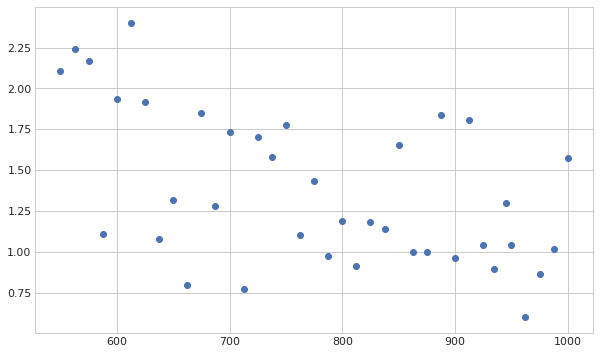

In [554]:
frac_an = [2.1047093 , 2.24281089, 2.16611316, 1.10671026, 1.93781416,
       2.39827954, 1.91504091, 1.07766751, 1.31920011, 0.79416602,
       1.84898383, 1.27802379, 1.73464467, 0.7721512 , 1.70095568,
       1.58280159, 1.77529039, 1.09981627, 1.43251272, 0.97705235,
       1.18825784, 0.9150671 , 1.18416207, 1.14115352, 1.6519543 ,
       0.99945712, 1.00099901, 1.83883042, 0.96433868, 1.8047252 ,
       1.04416522, 0.89545267, 1.29761692, 1.0409458 , 0.60057145,
       0.86444899, 1.01426618, 1.57182104]
plt.scatter(en_an, frac_an)

### 17 год

Моделирование по всем точкам даёт $\sigma_1$ = 5.77, $\sigma_2$ = 13.44

# Save fit info

In [286]:
fit_frame.to_csv(f'../outputs/{year}/tables/fit_frame.csv')

In [287]:
#mt.matrix(correlation=True)
#mt.draw_profile('Nsig');

In [288]:
dataN = fit_frame[['N','Nerr']]
dataN.columns = ['Nsig', 'dNsig']

In [289]:
dataN.tail()

,Nsig,dNsig
939.6,13.508678,4.522897
940.2,5.665648,4.394629
940.8,11.552445,5.013778
960.0,36.001240,8.245675
990.0,15.652315,5.111431


I have got table with events numbers

Now, I will get rid of m-field in the data table (because, I have used it)

In [290]:
data_info = final_data.drop_duplicates(['name','lum']).drop(['mass', 'trigger'], axis=1).set_index('name')

In [291]:
dataN = data_info.join(dataN, how='inner')
dataN

,lum,dEmin,dEmax,Emean,Nsig,dNsig
name,,,,,,
641.0,3097.960,0.00,0.00,641.02,329.451943,19.498623
650.0,876.635,0.00,0.00,649.77,99.984513,9.998704
675.0,1225.140,0.00,0.00,674.85,85.585588,10.044258
700.0,876.658,0.00,0.00,700.56,39.539176,6.909789
725.0,1114.220,0.00,0.00,724.94,62.339447,8.291776
750.0,1107.580,0.00,0.00,749.55,97.122267,10.480643
775.0,970.862,0.00,0.00,774.85,106.979811,10.342441
800.0,1241.540,0.00,0.00,800.86,165.801698,13.338868
825.0,1381.860,0.00,0.00,825.05,191.622425,14.294359


In [292]:
check_foo(dataN, fit_frame)

Good. 23 rows


OK, save it

In [293]:
dataN.to_csv(f'../outputs/{year}/tables/signal_table{year}.csv', float_format='%.2f')

Ok, now about triggers

In [294]:
triggers = final_data[['trigger','name']].set_index('name')
triggers = triggers.assign(one = 1);

In [295]:
triggers

,trigger,one
name,,
641.0,2,1
641.0,2,1
641.0,2,1
641.0,2,1
641.0,0,1
...,...,...
990.0,2,1
990.0,2,1
990.0,2,1


In [296]:
check_foo(triggers, final_data)

Good. 1776 rows


In [297]:
triggers = pd.pivot_table(triggers, values='one', columns=['trigger'], index='name', aggfunc=np.sum).fillna(0)

In [298]:
triggers.columns = ['TF', 'CF', 'TC']

In [299]:
triggers.head()

,TF,CF,TC
name,,,
641.0,83.0,4.0,258.0
650.0,13.0,0.0,87.0
675.0,25.0,4.0,64.0
700.0,11.0,1.0,31.0
725.0,13.0,2.0,49.0


In [300]:
def variance(k, n):
    return (k+1)*(k+2)/(n+2)/(n+3) - (k+1)**2/(n+2)**2

In [301]:
triggers['eTF'] = (triggers['TC'] + 1)/(triggers['CF'] + triggers['TC'] + 2)
triggers['eCF'] = (triggers['TC'] + 1)/(triggers['TF'] + triggers['TC'] + 2)
triggers['TrigEff'] = 1 - (1-triggers['eTF'])*(1-triggers['eCF'])

triggers['vTF'] = np.sqrt( variance(triggers['TC'], triggers['CF'] + triggers['TC']) )
triggers['vCF'] = np.sqrt( variance(triggers['TC'], triggers['TF'] + triggers['TC']) )
triggers['TrigErr'] = np.sqrt( np.square((1-triggers['eTF'])*triggers['vCF']) + 
                              np.square((1-triggers['eCF'])*triggers['vTF']) )

OK, trigers have been got

In [302]:
check_foo(triggers, dataN)

Good. 23 rows


In [303]:
triggers.to_csv(f'../outputs/{year}/tables/triggers{year}.csv', float_format='%.2f')

In [304]:
triggers

,TF,CF,TC,eTF,eCF,TrigEff,vTF,vCF,TrigErr
name,,,,,,,,,
641.0,83.0,4.0,258.0,0.981061,0.755102,0.995362,0.008374,0.023185,0.002097
650.0,13.0,0.0,87.0,0.988764,0.862745,0.998458,0.011110,0.033907,0.001572
675.0,25.0,4.0,64.0,0.928571,0.714286,0.979592,0.030564,0.047099,0.009358
700.0,11.0,1.0,31.0,0.941176,0.727273,0.983957,0.039772,0.066391,0.011529
725.0,13.0,2.0,49.0,0.943396,0.781250,0.987618,0.031447,0.051276,0.007466
750.0,24.0,3.0,75.0,0.950000,0.752475,0.987624,0.024216,0.042732,0.006364
775.0,20.0,2.0,85.0,0.966292,0.803738,0.993384,0.019024,0.038218,0.003950
800.0,36.0,3.0,133.0,0.971014,0.783626,0.993728,0.014230,0.031397,0.003211
825.0,49.0,2.0,146.0,0.980000,0.746193,0.994924,0.011393,0.030928,0.002957
